In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Let's define our model that we need to simulate
from scipy.signal import savgol_filter

from unified_model import unified
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel



In [3]:
# Magnet Assembly
magnet_assembly = mechanical_components.MagnetAssembly(
    m=2,
    l_m_mm=10,
    l_mcd_mm=24,
    dia_magnet_mm=10,
    dia_spacer_mm=10
)

In [4]:
mechanical_components.damper.QuasiKarnoppDamper?

Init signature:
mechanical_components.damper.QuasiKarnoppDamper(
    coulomb_damping_coefficient: float,
    motional_damping_coefficient: float,
    magnet_assembly: unified_model.mechanical_components.magnet_assembly.MagnetAssembly,
    tube_inner_radius_mm: float,
) -> None
Docstring:      A damper that is based on a modified Karnopp friction model.
Init docstring: Constructor
File:           ~/Nextcloud/PhD/Python/unified_model/unified_model/mechanical_components/damper.py
Type:           type
Subclasses:     


In [5]:
# Damper
damper = mechanical_components.damper.ConstantDamper(8.7857)

b_m1, b_m2 = (5.742857, 0.003333)

damper = mechanical_components.damper.QuasiKarnoppDamper(
    b_m1,
    b_m2,
    magnet_assembly,
    5.5 
)

In [6]:
damper.get_force(0.001)

0.0006528298112838265

In [7]:
# Top collision
mech_spring = mechanical_components.MechanicalSpring(
    magnet_assembly=magnet_assembly,
    position=150/1000,  # position of the microgenerator "top" (in metres)
    damping_coefficient=10  # Controls how "lossy" the impact is.
) 

mech_spring

MechanicalSpring(position=0.15, magnet_length=0.01, magnet_assembly_length=0.034, strength=10000000.0, damping_coefficient=10)

In [8]:
# Magnetic spring
magnetic_spring = mechanical_components.MagneticSpringInterp(
    fea_data_file='../data/magnetic-spring/10x10alt.csv',
    magnet_length=10 / 1000,
    filter_callable=lambda x: savgol_filter(x, window_length=27, polyorder=5)
)

In [9]:
# Electrical components
# Load
load = electrical_components.SimpleLoad(R=30)

# Rectifier loss
v_rect_drop = 0.1

In [10]:
# Params
c = 1
n_z = 88
n_w = 20

# Coupling model
coupling = CouplingModel().set_coupling_constant(4.1667)

# Coil
coil_config = electrical_components.coil.CoilConfiguration(
    c=c,
    n_z=n_z,
    n_w=n_w,
    l_ccd_mm=0,
    ohm_per_mm=1079/1000/1000,
    tube_wall_thickness_mm=1,
    coil_wire_radius_mm=0.143 / 2,
    coil_center_mm=91 - 13,  # Must be relative to *top* of fixed magnet
    inner_tube_radius_mm=5.5
)

In [11]:
import numpy as np
from flux_modeller.model import CurveModel

curve_model = CurveModel.load('../data/flux_curve_model.model')
# Predict the flux curve
X = np.array([[n_z, n_w]]).reshape(1, -1)
x_curve, phi_curve = curve_model.predict_curves(X)

# flux model
flux_model = electrical_components.FluxModelInterp(
    coil_config=coil_config,
    magnet_assembly=magnet_assembly
)

flux_model.fit(x_curve, phi_curve.reshape(-1))  # Fit flux curve

/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/electrical_components/flux/model.py:55: UserWarning: n_z and n_w are set, but are not required if no `curve_model` is specified.
  warnings.warn('n_z and n_w are set, but are not required if no `curve_model` is specified.')  # noqa


In [12]:
# Get our input excitation and groundtruth data
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any

@dataclass
class MechanicalGroundtruth:
    y_diff: Any
    time: Any

@dataclass
class ElectricalGroundtruth:
    emf: Any
    time: Any

@dataclass
class Groundtruth:
    mech: MechanicalGroundtruth
    elec: ElectricalGroundtruth

samples_list = collect_samples(base_path='../data/2021-03-05/',
                               acc_pattern='D/*acc*.csv',
                               adc_pattern='D/*adc*.csv',
                               video_label_pattern='D/*labels*.csv')
        
class GroundTruthFactory:
    def __init__(self,
                 samples_list,
                 lvp_kwargs,
                 adc_kwargs):
        """Helper Factory to get groundtruth data in a batch."""
        
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return MechanicalGroundtruth(y_target,
                                     y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return ElectricalGroundtruth(emf_target,
                                     emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            try:
                mech_groundtruth = self._make_mechanical_groundtruth(sample)
                elec_groundtruth = self._make_electrical_groundtruth(sample)

                groundtruths.append(
                    Groundtruth(mech_groundtruth, elec_groundtruth)
                )
            except AttributeError:
                pass

        return groundtruths


class AccelerometerInputsFactory:
    def __init__(self, sample_list, acc_input_kwargs=None):
        self.sample_list = sample_list
        self.acc_input_kwargs = {} if acc_input_kwargs is None else acc_input_kwargs  # noqa
        self._set_defaults()

    def _set_defaults(self):
        self.acc_input_kwargs.setdefault('accel_column', 'z_G'),
        self.acc_input_kwargs.setdefault('time_column', 'time(ms)'),
        self.acc_input_kwargs.setdefault('accel_unit', 'g'),
        self.acc_input_kwargs.setdefault('time_unit', 'ms'),
        self.acc_input_kwargs.setdefault('smooth', True),
        self.acc_input_kwargs.setdefault('interpolate', True)

    def make(self) -> np.ndarray:
        accelerometer_inputs = []
        for sample in self.sample_list:
            acc_input = mechanical_components.AccelerometerInput(
                raw_accelerometer_input=sample.acc_df,
                accel_column=self.acc_input_kwargs.setdefault('accel_column', 'z_G'),  # noqa
                time_column=self.acc_input_kwargs.setdefault('time_column', 'time(ms)'),  # noqa
                accel_unit=self.acc_input_kwargs.setdefault('accel_unit', 'g'),
                time_unit=self.acc_input_kwargs.setdefault('time_unit', 'ms'),
                smooth=self.acc_input_kwargs.setdefault('smooth', True),
                interpolate=self.acc_input_kwargs.setdefault('interpolate', True)  # noqa
            )
            accelerometer_inputs.append(acc_input)
        return np.array(accelerometer_inputs)
 
    
# Prepare data
groundtruth_factory = GroundTruthFactory(samples_list,
                                        lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                        seconds_per_frame=1/60,
                                                        pixel_scale=0.154508),
                                        adc_kwargs=dict(voltage_division_ratio=1 / 0.342))
accelerometer_factory = AccelerometerInputsFactory(samples_list)
groundtruth = groundtruth_factory.make()
input_excitations = accelerometer_factory.make()

/home/michael/Nextcloud/PhD/Python/unified_model/unified_model/utils/utils.py:446: UserWarning: There are a different number of groundtruth files, or some of them could not be found.
  warnings.warn('There are a different number of groundtruth files, or some of them could not be found.')


In [13]:
# Build the unified model
from unified_model import MechanicalModel
from unified_model import ElectricalModel
from unified_model import UnifiedModel
from unified_model import pipeline
from unified_model import governing_equations

mechanical_model = MechanicalModel() \
    .set_damper(damper) \
    .set_magnet_assembly(magnet_assembly) \
    .set_magnetic_spring(magnetic_spring) \
    .set_mechanical_spring(mech_spring) \

electrical_model = ElectricalModel() \
    .set_rectification_drop(v_rect_drop) \
    .set_load_model(load) \
    .set_flux_model(flux_model.flux_model, flux_model.dflux_model) \
    .set_coil_configuration(coil_config)

unified_model = UnifiedModel() \
    .set_mechanical_model(mechanical_model) \
    .set_electrical_model(electrical_model) \
    .set_coupling_model(coupling) \
    .set_post_processing_pipeline(pipeline.clip_x2, name='clip tube velocity') \
    .set_governing_equations(governing_equations.unified_ode)  # Here we set our governing equations for my particular microgenerator. We'll go over this a bit later.

In [14]:
def run(input_, groundtruth, unified_model):
    unified_model.mechanical_model.set_input(input_)
    y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
    unified_model.solve(t_start=0, t_end=8, y0=y0, t_eval=np.linspace(0, 8, 1000), t_max_step=1e-3)
    mech_result, mech_eval = unified_model.score_mechanical_model(
        y_target=groundtruth.mech.y_diff,
        time_target=groundtruth.mech.time,
        metrics_dict={'dtw_distance': metrics.dtw_euclid_distance},
        prediction_expr='x3-x1',
        return_evaluator=True
    )
    elec_result, elec_eval = unified_model.score_electrical_model(
        emf_target=groundtruth.elec.emf,
        time_target=groundtruth.elec.time,
        metrics_dict={'rms_perc_diff': metrics.root_mean_square_percentage_diff,
                      'rms': metrics.root_mean_square,
                     'dtw_distance': metrics.dtw_euclid_distance},
        prediction_expr='g(t, x5)',
        return_evaluator=True
    )
    
    print(mech_result, elec_result)
    mech_eval.poof()
    elec_eval.poof(figsize=(24, 8))


{'dtw_distance': 6.720741735265862} {'rms_perc_diff': 11.857223545457188, 'rms': (0.2604684500217744, 0.23285796103809397), 'dtw_distance': 186.80618920374334}


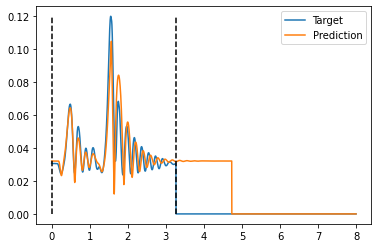

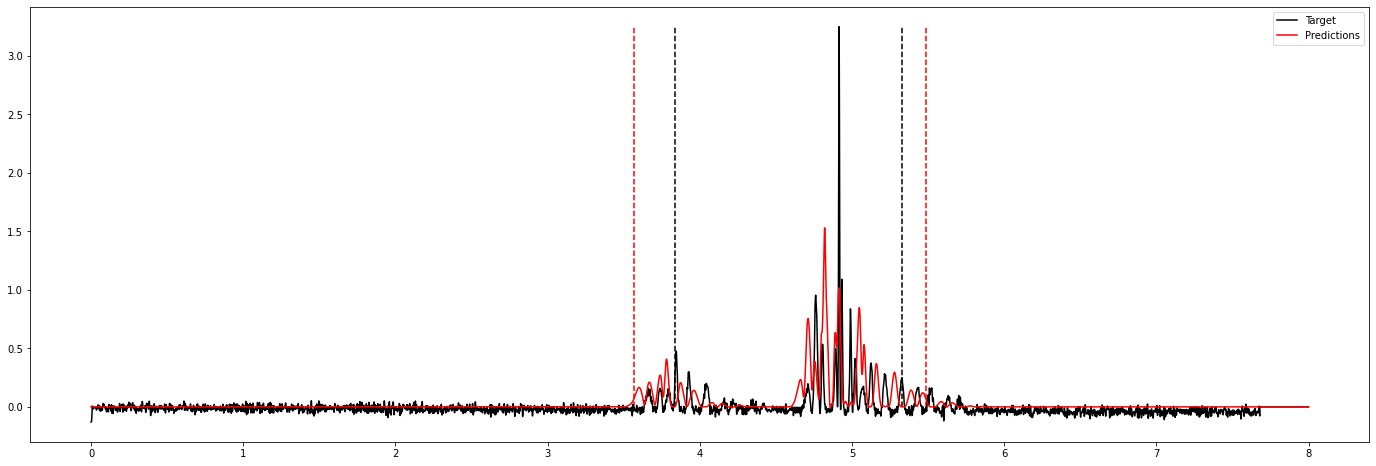

In [31]:
which = 1
run(input_excitations[which], groundtruth[which], unified_model)

In [13]:
# Run simulation
y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
unified_model.solve(t_start=0, t_end=8, y0=y0, t_eval=np.linspace(0, 8, 1000), t_max_step=1e-3)

In [14]:
results = unified_model.get_quick_results()
results.head()

,time,rel_pos_mag,rel_pos_vel,v_load
0,0.000000,0.032500,0.000000,0.0
1,0.008008,0.032486,-0.003359,0.0
2,0.016016,0.032447,-0.006288,0.0
3,0.024024,0.032387,-0.008640,0.0
4,0.032032,0.032311,-0.010312,0.0


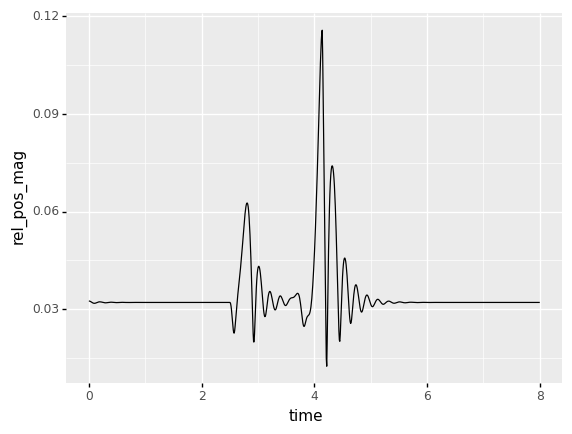

<ggplot: (8743927128073)>


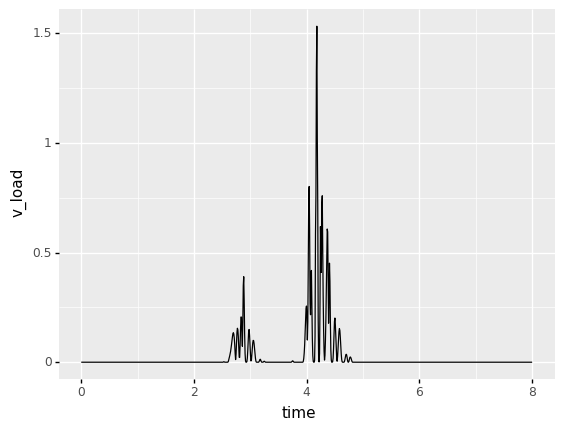

<ggplot: (8743927128313)>


In [15]:
from plotnine import *
print(qplot('time', 'rel_pos_mag', results, geom='line'))
print(qplot('time', 'v_load', results, geom='line'))

In [16]:
def calculate_rms(arr):
    square = arr**2
    sum_square = np.sum(square)
    sqrt_sum_square = np.sqrt(sum_square / len(arr))
    return sqrt_sum_square

unified_model.calculate_metrics(prediction_expr='g(t, x5)', metric_dict={'rms': calculate_rms})

{'rms': 0.12047975983173448}